In [10]:
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for hmmlearn from https://files.pythonhosted.org/packages/c8/5f/65b892737fed694b23a753b516cd851d21963abd33ea86123723f6279987/hmmlearn-0.3.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/127.0 kB ? eta -:--:--
   ---------------------------------------- 127.0/127.0 kB 3.8 MB/s eta 0:00:00


Forward Algorithm Final Probability: 0.0315
Backward Algorithm Final Probability: 0.0315
Viterbi Algorithm Most Likely State Sequence: [0 1 0]
Viterbi Algorithm Best Path Probability: 0.0189


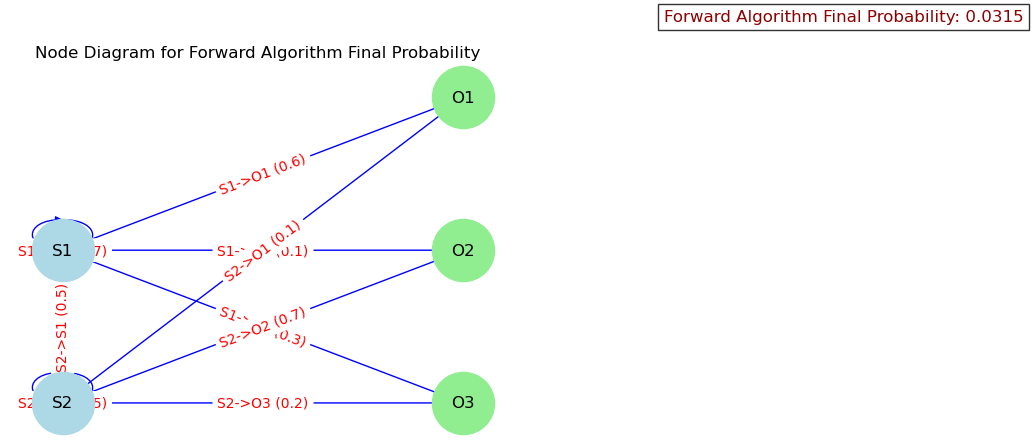

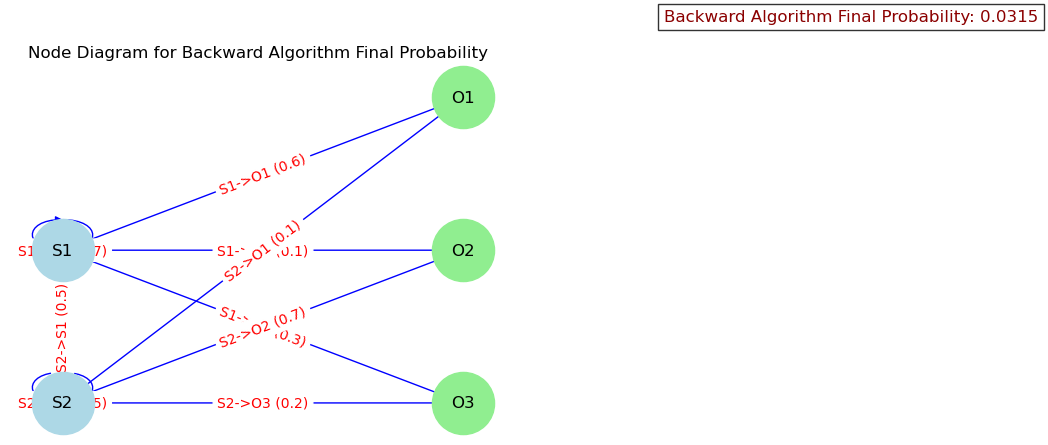

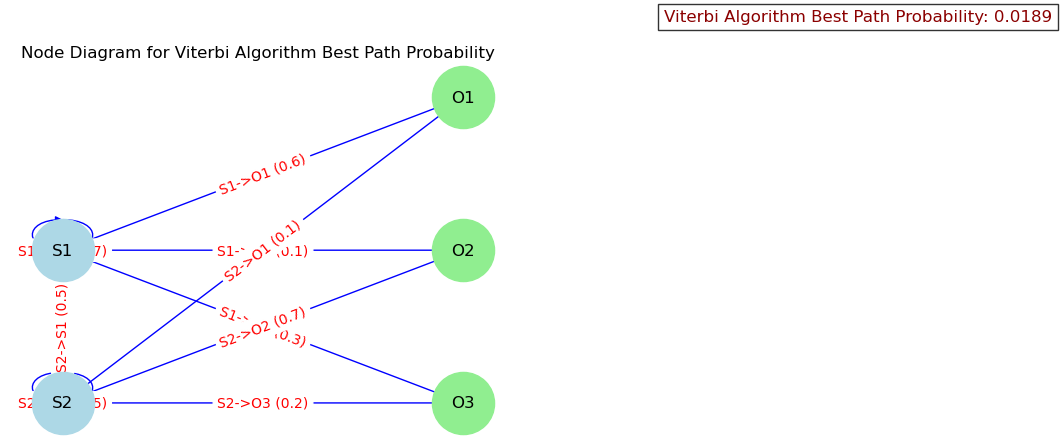

In [9]:
import sys
import subprocess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Check if hmmlearn is installed
try:
    from hmmlearn import hmm
except ModuleNotFoundError:
    print("The 'hmmlearn' package is not installed. Installing it now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "hmmlearn"])
    from hmmlearn import hmm

# Define the HMM model
model = hmm.CategoricalHMM(n_components=2, n_iter=100, tol=0.01)
model.startprob_ = np.array([1, 0])  # Initial probabilities
model.transmat_ = np.array([[0.7, 0.3], [0.5, 0.5]])  # Transition probabilities
model.emissionprob_ = np.array([[0.6, 0.1, 0.3], [0.1, 0.7, 0.2]])  # Emission probabilities

# Observed sequence
words = np.array([[3, 2, 1]]) - 1  # Adjust indices to zero-based
words = words.reshape(-1, 1)  # Reshape to 2D array

# Compute Forward Probability
log_prob_forward = model.score(words)  # Log probability of the sequence
forward_prob = np.exp(log_prob_forward)  # Convert log probability to normal probability

# Decode Most Likely State Sequence (Viterbi Algorithm)
log_prob_viterbi, viterbi_path = model.decode(words)
viterbi_prob = np.exp(log_prob_viterbi)

# Backward Algorithm Implementation
def backward_algorithm(pi, transition, emission, words):
    T = len(words)
    beta = [[1] * len(pi)]  # Initialize beta_T(i) = 1 for all states
    for t in range(T - 1, 0, -1):
        ok = words[t]  # Observation at time t
        beta_t = [
            round(
                sum(
                    transition[i][j] * emission[j][ok[0]] * beta[0][j]
                    for j in range(len(transition))
                ),
                4,
            )
            for i in range(len(transition))
        ]
        beta.insert(0, beta_t)  # Insert at the beginning
    # Compute final probability
    ok = words[0]  # First observation
    final_prob = sum(
        pi[i] * emission[i][ok[0]] * beta[0][i] for i in range(len(pi))
    )
    return round(final_prob, 4), beta

# Run Backward Algorithm
backward_prob, _ = backward_algorithm(model.startprob_, model.transmat_, model.emissionprob_, words)

# Print Results
print("Forward Algorithm Final Probability:", round(forward_prob, 4))
print("Backward Algorithm Final Probability:", backward_prob)
print("Viterbi Algorithm Most Likely State Sequence:", viterbi_path)
print("Viterbi Algorithm Best Path Probability:", round(viterbi_prob, 4))

# Node Diagram Visualization
def draw_node_diagram(algorithm_name, final_probability):
    G = nx.DiGraph()
    states = ["S1", "S2"]
    observations = ["O1", "O2", "O3"]
    G.add_nodes_from(states + observations)

    # Add edges
    edges = {
        ("S1", "S1"): 0.7, ("S1", "S2"): 0.3,
        ("S2", "S1"): 0.5, ("S2", "S2"): 0.5,
        ("S1", "O1"): 0.6, ("S1", "O2"): 0.1, ("S1", "O3"): 0.3,
        ("S2", "O1"): 0.1, ("S2", "O2"): 0.7, ("S2", "O3"): 0.2
    }
    for (u, v), w in edges.items():
        G.add_edge(u, v, label=f"{u}->{v} ({w})")

    # Position nodes
    pos = {"S1": (0, 1), "S2": (0, 0), "O1": (1, 2), "O2": (1, 1), "O3": (1, 0)}

    # Draw graph
    nx.draw_networkx_nodes(G, pos, nodelist=states, node_color="lightblue", node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=observations, node_color="lightgreen", node_size=2000)
    nx.draw_networkx_edges(G, pos, edge_color="blue", arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Annotate final probability
    plt.text(1.5, 2.5, f"{algorithm_name}: {final_probability}", fontsize=12, color="darkred",
             bbox=dict(facecolor="white", alpha=0.8))

    plt.title(f"Node Diagram for {algorithm_name}")
    plt.axis("off")
    plt.show()

# Draw Node Diagrams
draw_node_diagram("Forward Algorithm Final Probability", round(forward_prob, 4))
draw_node_diagram("Backward Algorithm Final Probability", backward_prob)
draw_node_diagram("Viterbi Algorithm Best Path Probability", round(viterbi_prob, 4))

Forward Algorithm Final Probability: 0.0308
Backward Algorithm Final Probability: 0.0315
Viterbi Algorithm Most Likely State Sequence: [0, 0, 1, 0]
Viterbi Algorithm Best Path Probability: 0.0132


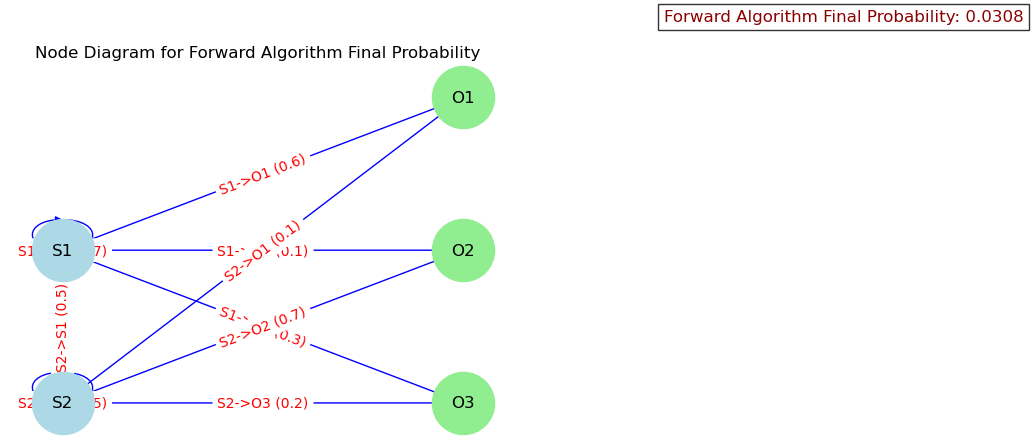

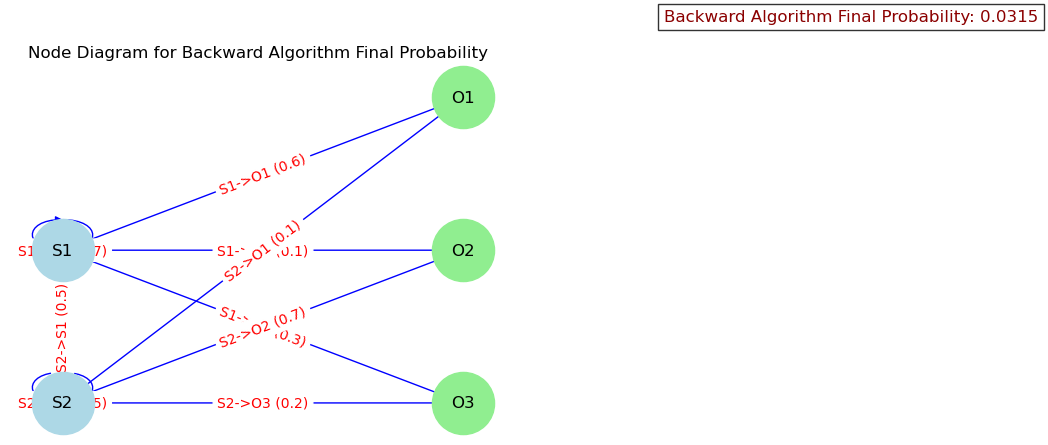

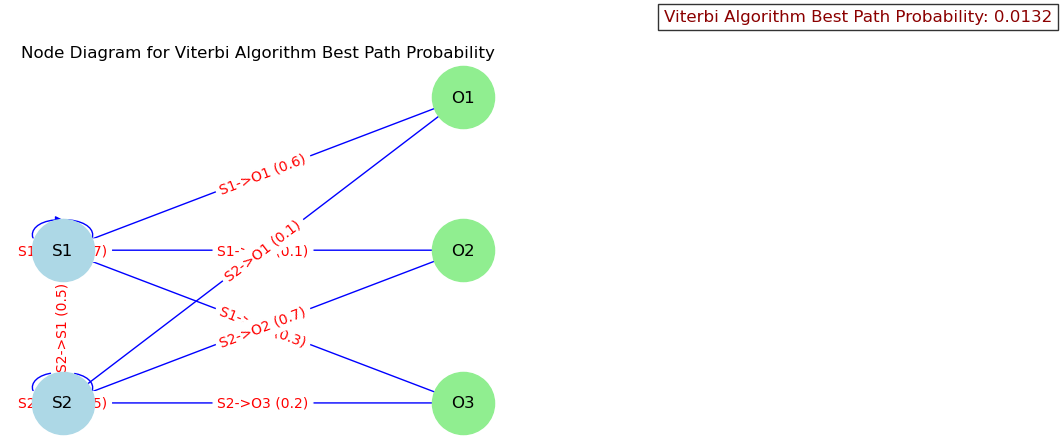

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Forward Algorithm
def forward_algorithm(pi, transition, emission, words):
    alpha = [pi]
    for t in range(len(words)):
        ok = words[t] - 1  # Adjust index for zero-based indexing
        alpha.append([round(sum(alpha[-1][i] * transition[i][j] * emission[j][ok] for i in range(len(transition))), 4)
                      for j in range(len(transition))])
    return round(sum(alpha[-1]), 4), alpha

# Backward Algorithm
def backward_algorithm(pi, transition, emission, words):
    T = len(words)
    beta = [[1] * len(pi)]  # Initialize beta_T(i) = 1 for all states
    for t in range(T - 1, 0, -1):
        ok = words[t] - 1  # Adjust index for zero-based indexing
        beta.insert(0, [round(sum(transition[i][j] * emission[j][ok] * beta[0][j] for j in range(len(transition))), 4)
                        for i in range(len(transition))])
    # Compute final probability
    ok = words[0] - 1
    return round(sum(pi[i] * emission[i][ok] * beta[0][i] for i in range(len(pi))), 4), beta

# Viterbi Algorithm
def viterbi_algorithm(pi, transition, emission, words):
    delta, psi = [pi[:]], [[]]
    for t in range(len(words)):
        ok = words[t] - 1
        delta_t = [max(delta[-1][i] * transition[i][j] * emission[j][ok] for i in range(len(transition)))
                   for j in range(len(transition))]
        psi_t = [max(range(len(transition)), key=lambda i: delta[-1][i] * transition[i][j] * emission[j][ok])
                 for j in range(len(transition))]
        delta.append(delta_t)
        psi.append(psi_t)
    best_path_prob = max(delta[-1])
    best_path_end = delta[-1].index(best_path_prob)
    best_path = [best_path_end]
    for t in range(len(words), 0, -1):
        best_path.insert(0, psi[t][best_path[0]])
    return best_path, round(best_path_prob, 4)

# Inputs
pi = [1, 0]  # Initial state probabilities
transition = [[0.7, 0.3], [0.5, 0.5]]  # Transition probabilities
emission = [[0.6, 0.1, 0.3], [0.1, 0.7, 0.2]]  # Emission probabilities
words = [3, 2, 1]  # Observed sequence

# Run Algorithms
forward_prob, _ = forward_algorithm(pi, transition, emission, words)
backward_prob, _ = backward_algorithm(pi, transition, emission, words)
viterbi_path, viterbi_prob = viterbi_algorithm(pi, transition, emission, words)

# Print Results
print("Forward Algorithm Final Probability:", forward_prob)
print("Backward Algorithm Final Probability:", backward_prob)
print("Viterbi Algorithm Most Likely State Sequence:", viterbi_path)
print("Viterbi Algorithm Best Path Probability:", viterbi_prob)

# Node Diagram Visualization
def draw_node_diagram(algorithm_name, final_probability):
    G = nx.DiGraph()
    states = ["S1", "S2"]
    observations = ["O1", "O2", "O3"]
    G.add_nodes_from(states + observations)

    # Add edges
    edges = {
        ("S1", "S1"): 0.7, ("S1", "S2"): 0.3,
        ("S2", "S1"): 0.5, ("S2", "S2"): 0.5,
        ("S1", "O1"): 0.6, ("S1", "O2"): 0.1, ("S1", "O3"): 0.3,
        ("S2", "O1"): 0.1, ("S2", "O2"): 0.7, ("S2", "O3"): 0.2
    }
    for (u, v), w in edges.items():
        G.add_edge(u, v, label=f"{u}->{v} ({w})")

    # Position nodes
    pos = {"S1": (0, 1), "S2": (0, 0), "O1": (1, 2), "O2": (1, 1), "O3": (1, 0)}

    # Draw graph
    nx.draw_networkx_nodes(G, pos, nodelist=states, node_color="lightblue", node_size=2000)
    nx.draw_networkx_nodes(G, pos, nodelist=observations, node_color="lightgreen", node_size=2000)
    nx.draw_networkx_edges(G, pos, edge_color="blue", arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Annotate final probability
    plt.text(1.5, 2.5, f"{algorithm_name}: {final_probability}", fontsize=12, color="darkred",
             bbox=dict(facecolor="white", alpha=0.8))

    plt.title(f"Node Diagram for {algorithm_name}")
    plt.axis("off")
    plt.show()

# Draw Node Diagrams
draw_node_diagram("Forward Algorithm Final Probability", forward_prob)
draw_node_diagram("Backward Algorithm Final Probability", backward_prob)
draw_node_diagram("Viterbi Algorithm Best Path Probability", viterbi_prob)